In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold

from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from catboost import CatBoostRegressor
from transliterate import translit

from src.get_metrics import get_metrics_regression, rmsle, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import shap


import warnings
from warnings import simplefilter
from src.baseline_fun import cyrillic_to_latin, check_overfitting, fill_mode_group_by, fill_missing_values

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 25
N_FOLDS = 5

## Baseline
We will teach basic algorithms and analyze them for further tuning.

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
dataset_path = os.path.join(parent_dir, "data", "df_eda.csv")

In [3]:
# Uploading data
df = pd.read_csv(dataset_path, index_col=0)

- link - link to the listing  
- price - price  
- district_value - city district  
- address_value - postal address  
- house_type_value - house type  
- apartment_type - apartment type  
- renovation - type of renovation  
- area_documents - area as per documents  
- floor - floor  
- balcony_loggia - presence of a balcony/loggia  
- construction_status - building status (completed/not completed)  
- mortgage - mortgage eligibility (eligible/not eligible)  
- description - description  
- description2 - additional description  
- year - year of construction  
- data - listing date  
- city - city  
- floor_area - number of floors  
- city_kr - city in Cyrillic  
- lat - latitude  
- lon - longitude  
- building_age - building age in years  
- distance - distance to the city center  
- price_per_meter - price per square meter  
- price_log - log-transformed price  
- parsed_date - listing publication date in date format  
- announcement_age - listing age in months  

In [4]:
# Let's display information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22788 entries, 0 to 22787
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   link                 22788 non-null  object 
 1   price                22788 non-null  float64
 2   district_value       22456 non-null  object 
 3   address_value        22788 non-null  object 
 4   house_type_value     17221 non-null  object 
 5   apartment_type       22788 non-null  object 
 6   renovation           16081 non-null  object 
 7   area_documents       22788 non-null  float64
 8   floor                22788 non-null  int64  
 9   balcony_loggia       22788 non-null  object 
 10  construction_status  22788 non-null  object 
 11  mortgage             22788 non-null  object 
 12  description          22788 non-null  object 
 13  description2         22640 non-null  object 
 14  year                 10246 non-null  float64
 15  data                 22788 non-null  obje

In [5]:
# Let's convert all Cyrillic characters to Latin characters
df = cyrillic_to_latin(df)
df[:5]

,link,price,district_value,address_value,house_type_value,apartment_type,renovation,area_documents,floor,balcony_loggia,...,lat,lon,price_per_meter,parsed_date,announcement_age,floor_area,distance,price_log,age_bin,floor_bin
0,https://www.farpost.ru/nakhodka/realty/sell_fl...,1499000.0,Rybnyj port,prospekt Nahodkinskij 78,kirpichnyj,Dolja,Bez remonta,40.0,4,Net,...,42.792168,132.868521,3.747500e+04,2024-09-10,0,5,4060.577670,14.220309,25-80,0-5
1,https://www.farpost.ru/nakhodka/realty/sell_fl...,2500000.0,Zavodskaja,ulitsa Nahimovskaja 35,kirpichnyj,Dolja,NaN,45.0,1,Est',...,42.804036,132.861535,5.555556e+04,2024-09-10,0,5,3389.184714,14.731802,25-80,0-5
2,https://www.farpost.ru/nakhodka/realty/sell_fl...,500000.0,Gagarina (Tretij uchastok),ulitsa Dobroljubova 5,monolitnyj,Dolja,Kosmeticheskij,42.2,1,Net,...,42.786968,132.852911,1.184834e+04,2023-09-28,11,4,5255.442187,13.122365,25-80,0-5
3,https://www.farpost.ru/nakhodka/realty/sell_fl...,4640000.0,Mor. uchilische,ulitsa Timirjazeva 1a,kirpichnyj,Dolja,Evroremont,108.4,4,Est',...,42.787113,132.859260,4.280443e+04,2023-09-19,12,10,4936.217529,15.350225,25-80,0-5
4,https://www.farpost.ru/nakhodka/realty/sell_fl...,3700000.0,Severnyj mikrorajon,ulitsa Frunze 13,derevjannyj,Dolja,NaN,1.0,5,Net,...,42.852468,132.962683,3.700000e+06,2017-08-18,86,5,6526.377958,15.123844,25-80,0-5


Let's remove the features we won't use:

- 1) 'link' - attribute with unique values
- 2) 'city_kr' - double of the 'city' feature
- 3) 'description', 'description2' - not used
- 4) 'lat', 'lon' - used for distance calculation, not used in the model
- 5) 'data', 'parsed_date' - used to calculate ageLet's remove the features we won't use:

In [6]:
df = df.drop(columns=['link', 'city_kr', 'description', 'description2',
             'lat', 'lon', 'data', 'parsed_date'], axis=1)

In [7]:
dataset_path_save = os.path.join(parent_dir, "data", "df_base.csv")

In [8]:
# save to a file for use in stacking
df.to_csv(dataset_path_save, index=True)

In [9]:
# Create a list of categorical features
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['district_value', 'address_value', 'house_type_value', 'apartment_type',
       'renovation', 'balcony_loggia', 'construction_status', 'mortgage',
       'city', 'age_bin', 'floor_bin'],
      dtype='object')

In [10]:
# Changing the type of categorical fiches to “category”
df[cat_cols] = df[cat_cols].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22788 entries, 0 to 22787
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   price                22788 non-null  float64 
 1   district_value       22456 non-null  category
 2   address_value        22788 non-null  category
 3   house_type_value     17221 non-null  category
 4   apartment_type       22788 non-null  category
 5   renovation           16081 non-null  category
 6   area_documents       22788 non-null  float64 
 7   floor                22788 non-null  int64   
 8   balcony_loggia       22788 non-null  category
 9   construction_status  22788 non-null  category
 10  mortgage             22788 non-null  category
 11  year                 10246 non-null  float64 
 12  building_age         10246 non-null  float64 
 13  city                 22788 non-null  category
 14  price_per_meter      22788 non-null  float64 
 15  announcement_age     227

In [11]:
# Form a dictionary with fiches to fill and attributes to group.
fill_dict = {
    'district_value': 'city',   # Fill the district of a city in city-specific fashion
    'house_type_value': 'city', # Fill in the house type in a city-specific fashion
    'renovation': 'city',       # Fill in the renovation type in a city-specific fashion.
    'year': 'city',             # Fill in the year the house was built with city-specific mods.
    'building_age': 'city',     # Fill in the age of the house with city-specific mods.
    'age_bin': 'city',          # Fill in the age bin of the house with city-specific mods
}

- Split the dataset into **test, train** and **val**.
- We remove **'price', 'price_log', 'price_per_meter'** from the attributes.
- On **baseline**, **'price'** will be predicted, since the error interpretation on **'price_log'** and **'price_per_meter'** targets is less informative.

In [12]:
X = df.drop(['price', 'price_log', 'price_per_meter'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

# Fill in the blanks
X_train = fill_missing_values(X_train, fill_dict)
X_test = fill_missing_values(X_test, fill_dict)
X_train_ = fill_missing_values(X_train_, fill_dict)
X_val = fill_missing_values(X_val, fill_dict)

Since there is a lot of categorical data in the dataset, we take as base algorithms that can work with it without additional processing - these are LightGBM and CatBoost.

## LightGBM

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 740312


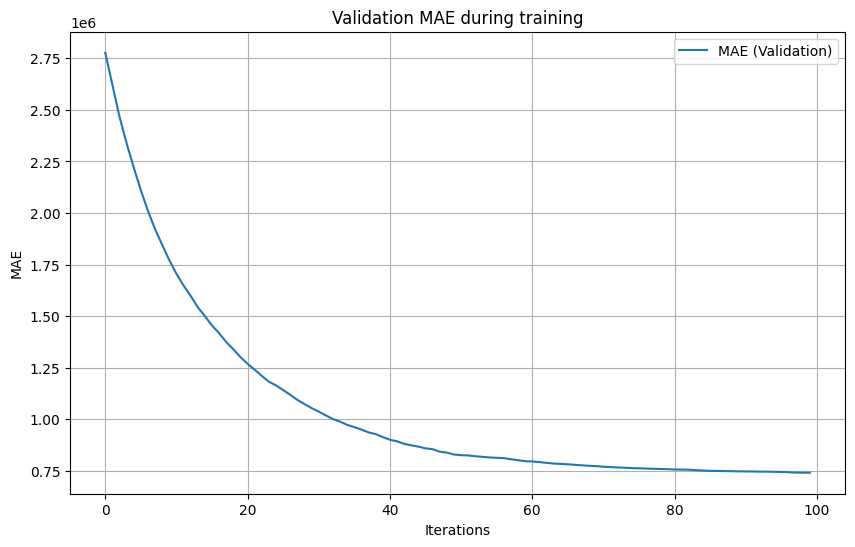

In [13]:
early_stopping_callback = early_stopping(stopping_rounds=100)

lgbm_base = LGBMRegressor(random_state=RAND, objective='mae', verbosity=-1)


eval_set = [(X_val, y_val)]

lgbm_base.fit(X_train_,
              y_train_,
              eval_metric="mae",
              eval_set=eval_set,
              callbacks=[early_stopping_callback],
              )

y_pred = lgbm_base.predict(X_test)

# Obtaining training data (metrics at each round)
eval_results = lgbm_base.evals_result_[
    'valid_0']['l1']  # 'l1' corresponds to the MAE metric

plt.figure(figsize=(10, 6))
plt.plot(eval_results, label='MAE (Validation)')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Validation MAE during training')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
check_overfitting(lgbm_base,
                  X_train_,
                  y_train_,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 682492.239
mean_absolute_error test: 738981.972
delta = 7.6 %


The model was trained with an allowable overfitting of 7.6%.

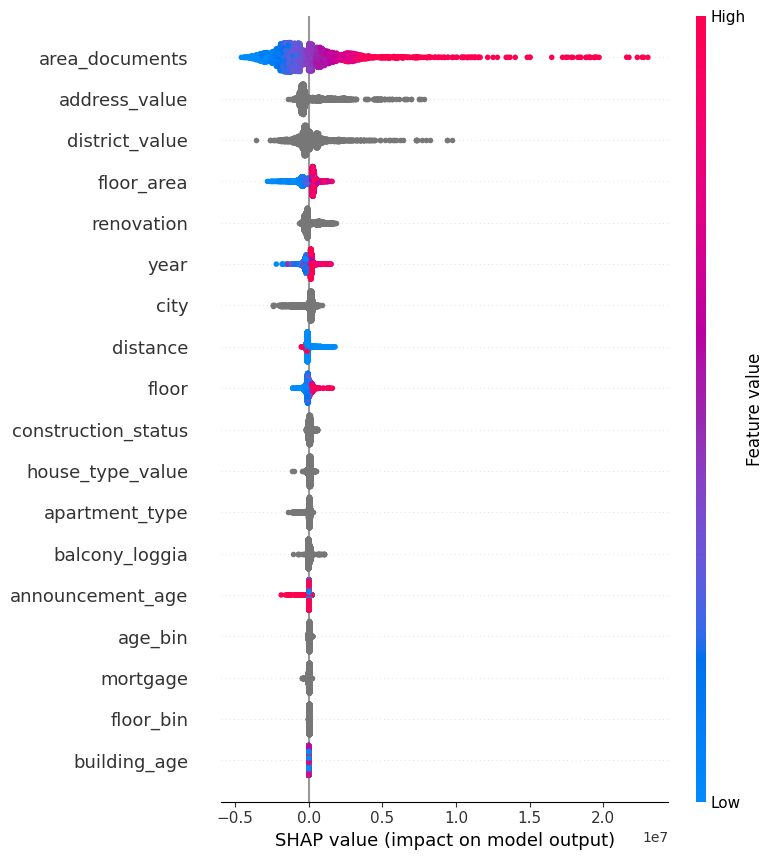

In [15]:
# Creating an explainer using the trained model
explainer = shap.TreeExplainer(
    lgbm_base, feature_perturbation="tree_path_dependent")

# Obtaining SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Draw a summary chart of SHAP values
shap.summary_plot(shap_values, X_test)

In [16]:
r = permutation_importance(lgbm_base,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

feature_imp

,column,value,2_std
5,area_documents,0.735707,0.037975
0,district_value,0.167186,0.006202
1,address_value,0.075331,0.005498
14,floor_area,0.032647,0.001142
10,year,0.026689,0.006568
12,city,0.024495,0.000971
15,distance,0.019420,0.001352
4,renovation,0.019024,0.001522
7,balcony_loggia,0.015073,0.011247
6,floor,0.006793,0.001810


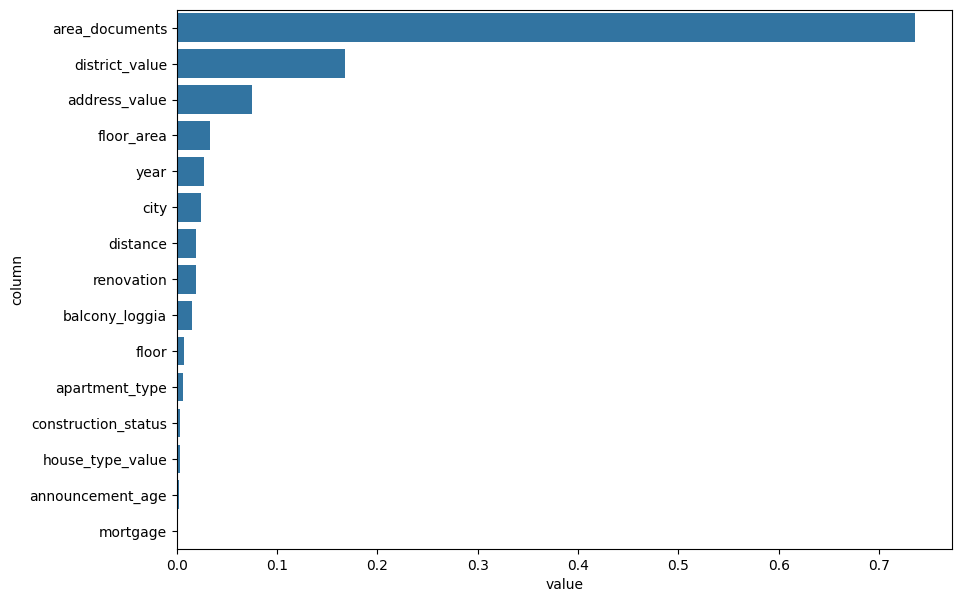

In [17]:
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

The feature **area_documents** dominates significantly, which needs to be taken into account during tuning.

In [18]:
metrics = get_metrics_regression(y_test=y_test,
                                 y_pred=y_pred,
                                 X_test=X_test,
                                 name='LGBMRegressor_baseline')

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LGBMRegressor_baseline,738981.972,4.866899e+12,2206105.015,0.832,-3.265,11.121,9.096


##  CatBoost

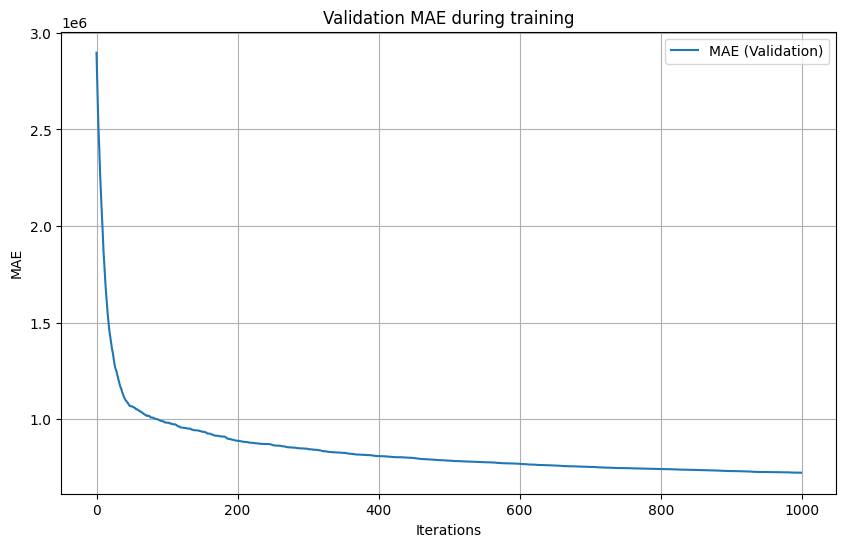

In [19]:
cat_cols = list(cat_cols)

cb_base = CatBoostRegressor(allow_writing_files=False,
                            random_state=RAND,
                            eval_metric="MAE",
                            cat_features=cat_cols)
eval_set = [(X_val, y_val)]

cb_base.fit(X_train_,
            y_train_,
            eval_set=eval_set,
            verbose=False,
            early_stopping_rounds=100)

y_pred = cb_base.predict(X_test)

# Получение данных об обучении (метрики на каждом раунде)
eval_results = cb_base.get_evals_result()['validation']['MAE']

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(eval_results, label='MAE (Validation)')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Validation MAE during training')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
check_overfitting(cb_base, X_train_, y_train_,
                  X_test, y_test, mean_absolute_error)

mean_absolute_error train: 603618.715
mean_absolute_error test: 732897.751
delta = 17.6 %


The model was trained with overfitting of 17.6%.

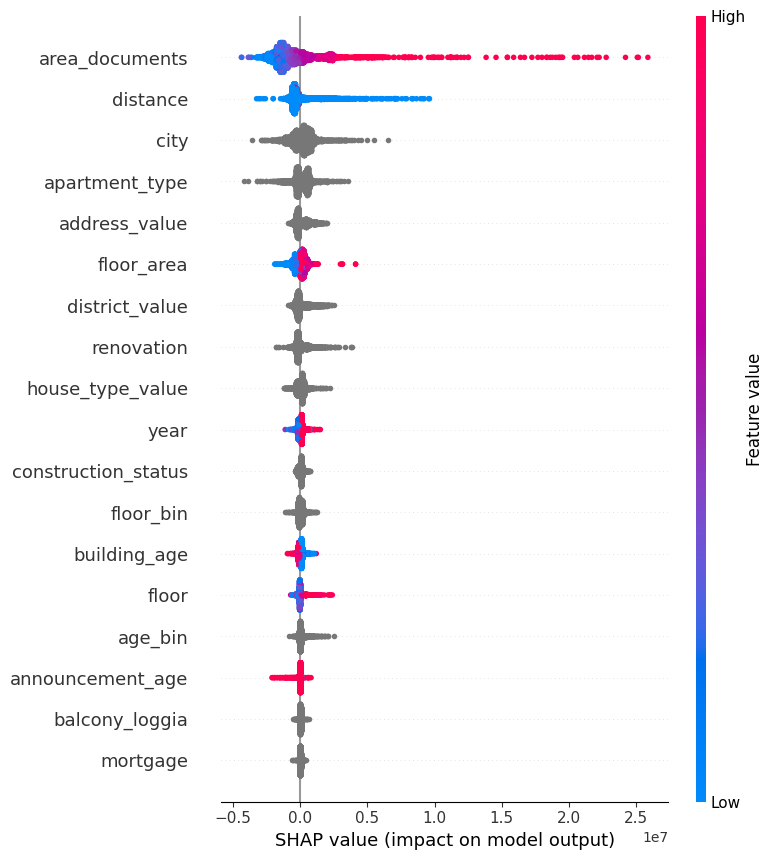

In [21]:
# We are creating an explainer using the trained model.
explainer = shap.TreeExplainer(
    cb_base, feature_perturbation="tree_path_dependent")

# We obtain SHAP values for the test set.
shap_values = explainer.shap_values(X_test)

# We plot a summary diagram of SHAP values.
shap.summary_plot(shap_values, X_test)

In [22]:
r = permutation_importance(cb_base,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

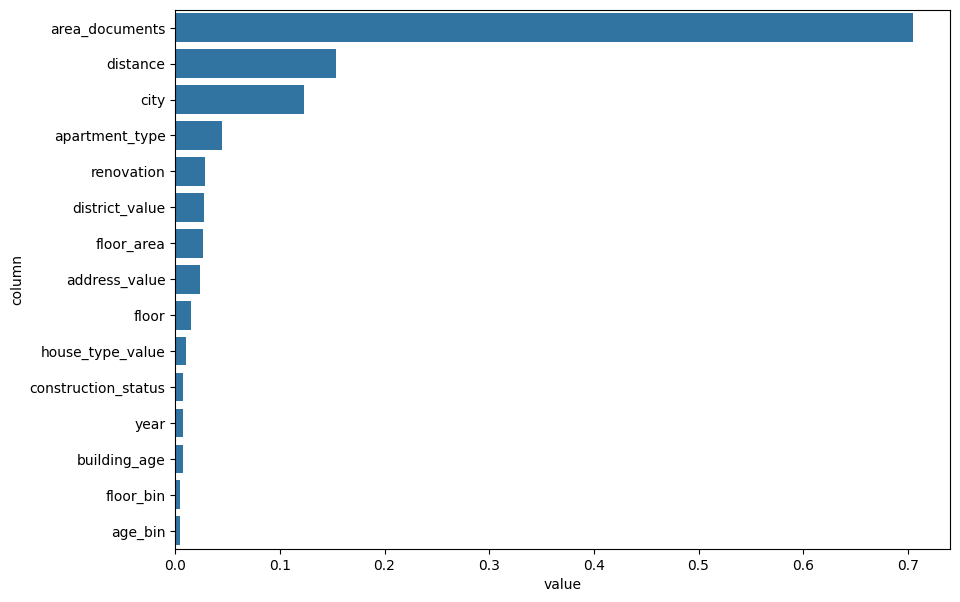

In [23]:
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

In [24]:
metrics = pd.concat([
    metrics,
    get_metrics_regression(y_test=y_test,
                           y_pred=y_pred,
                           X_test=X_test,
                           name='CatBoostRegressor_baseline')
])

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,
LGBMRegressor_baseline,738981.972,4.866899e+12,2206105.015,0.832,-3.265,11.121,9.096
CatBoostRegressor_baseline,732897.751,3.771927e+12,1942144.985,0.870,-3.090,10.573,9.021


### 1. **Model Metrics**
   - **LGBMRegressor_baseline** and **CatBoostRegressor_baseline** showed the following results:
     - **MAE** (Mean Absolute Error): The price error is slightly higher for `LGBMRegressor_baseline_log` (738982) compared to `CatBoostRegressor_baseline` (732898). This indicates that CatBoost predicts prices better, although the difference is small.
     - **MSE** (Mean Squared Error): The value is also higher for `LGBMRegressor_baseline`, confirming that LGBM has larger errors.
     - **RMSE** (Root Mean Squared Error): The `LGBMRegressor_baseline` RMSE is 2206105, which is higher than CatBoost's (1942145), indicating better performance by CatBoost in cases with larger errors.
     - **R2 adjusted**: CatBoost again shows a higher value (0.870 versus 0.832), indicating that it better explains the data variation.
     - **MPE_%** (Mean Percentage Error): Both models have negative mean percentage errors, which may indicate some systematic underestimation. However, CatBoost (-3.090%) underestimates less than LGBM (-3.265%).
     - **MAPE_%** and **WAPE_%**: Again, CatBoost performs slightly better on these metrics, reflecting its overall stability and accuracy.

### 2. **Check_overfitting**
   - For **LGBMRegressor_baseline_log**:
     - **MAE on training set**: 682492.239
     - **MAE on test set**: 738981.972
     - **Difference (delta)**: 7.6%, indicating slight overfitting. However, the difference is small and acceptable for the model.
   - For **CatBoostRegressor_baseline**:
     - **MAE on training set**: 603618.715
     - **MAE on test set**: 732897.751
     - **Difference (delta)**: 17.6%, indicating more overfitting compared to LGBM. This suggests that CatBoost has fitted the training data more precisely but generalizes less effectively on the test set.

### Conclusions:
- **CatBoost** performs better at predicting prices, based on its metrics on the test set, especially MSE, RMSE, and R2. This highlights its overall superiority in prediction quality.
- **LGBM** exhibits less overfitting (7.6% versus 17.6%) but has higher absolute errors on the test set, which may suggest it captures the dependencies in the data less effectively.
- **Recommendation**: If the goal is to minimize MAE and ensure a more stable model, CatBoost appears to be the better choice. However, if a lower level of overfitting is required, LGBM could be considered, or additional regularization could be applied to CatBoost.